## Applying local tools over NAIP (National Agriculture Imagery Program) data

In this notebook, will be demonstrated the application of the Xarray-spatial local tools over the **NAIP** data hosted in the [Planetary Computer Data Catalog](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a). In the process, we'll see how to:
- Access the NAIP data with the Planetary Computer STAC API.
- Search for a sample region over three-date scenes of interest and render the images.
- Explore the [Xarray-spatial](https://xarray-spatial.org/) local tools functions.

Some of the examples used in this notebook were adapted from [Accessing NAIP data with the Planetary Computer STAC API](https://planetarycomputer-staging.microsoft.com/dataset/naip#Example-Notebook) and [An overview of the Local toolset](https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/an-overview-of-the-local-tools.htm).

### Accessing NAIP data with the Planetary Computer STAC API

#### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.

In [1]:
from pystac_client import Client
import planetary_computer as pc

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)

#### Choose our region and times of interest

This area is in the Simplot Family farm, one of the largest farms in the US, located outside of Boise Idaho.  Let's see whether we can see some development in this area in the time spanned by our NAIP collection.

In [2]:
area_of_interest = {
    'type': 'Polygon',
    'coordinates': [
        [
            [-116.05,43.03],
            [-115.97,43.03],
            [-115.97,43.07],
            [-116.05,43.07],
            [-116.05,43.03]            
        ]
    ],
}

#### Search the collection and choose scenes to render

Use [pystac-client](https://github.com/stac-utils/pystac-client) to search for data from the [NAIP](http://aka.ms/ai4edata-naip) collection.  This collection includes data from 2010 to 2019, so we'll search for one image near the beginning of that range, one near the middle, and one near the end.

In [3]:
range1 = '2010-01-01/2013-01-01'
range2 = '2013-01-01/2017-01-01'
range3 = '2018-01-01/2020-01-01'

In [4]:
catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')

search1 = catalog.search(
    collections=['naip'], 
    intersects=area_of_interest,
    datetime = range1
)

search2 = catalog.search(
    collections=['naip'], 
    intersects=area_of_interest,
    datetime = range2
)

search3 = catalog.search(
    collections=['naip'], 
    intersects=area_of_interest,
    datetime = range3
)

print(f'{search1.matched()} Items found in the range 1')
print(f'{search2.matched()} Items found in the range 2')
print(f'{search3.matched()} Items found in the range 3')

4 Items found in the range 1
4 Items found in the range 2
4 Items found in the range 3


As seen above, there are multiple items that intersect our area of interest for each year. The following code will choose the item that has the most overlap.

In [5]:
from shapely.geometry import shape

area_shape = shape(area_of_interest)
target_area = area_shape.area

def area_of_overlap(item):
    overlap_area = shape(item.geometry).intersection(shape(area_of_interest)).area    
    return overlap_area / target_area

item1 = sorted(search1.items(), key=area_of_overlap, reverse=True)[0]
item2 = sorted(search2.items(), key=area_of_overlap, reverse=True)[0]
item3 = sorted(search3.items(), key=area_of_overlap, reverse=True)[0]

#### Render images

Each Item has an `href` field containing a URL to the underlying image. For NAIP, these URLs are publicly-accessible, but for some data sets, these URLs may point to private containers, so we demonstrate the use of the [planetary-computer](https://github.com/microsoft/planetary-computer-sdk-for-python) package's `pc.sign` method, which adds a [Shared Access Signature](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview) to the URL, after which it can be used by any tooling that expects a standard URL.

In [6]:
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image

red_band = 1
green_band = 2
blue_band = 3
nir_band = 4

def create_image(item):
    print(item.datetime)
    href = pc.sign(item.assets['image'].href)
    with rasterio.open(href) as ds:    
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds('epsg:4326', ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        band_data = ds.read(indexes=[nir_band, red_band], window=aoi_window)

    img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
    w = img.size[0]; h = img.size[1]; aspect = w/h


    # Downscale a bit for plotting
    target_w = 800; target_h = (int)(target_w/aspect)

    return img.resize((target_w,target_h),Image.BILINEAR)

In [7]:
%%time

img1 = create_image(item1)
img2 = create_image(item2)
img3 = create_image(item3)

2011-07-01 00:00:00+00:00
2013-08-18 00:00:00+00:00
2019-07-14 00:00:00+00:00
CPU times: user 10.8 s, sys: 1.03 s, total: 11.8 s
Wall time: 22.8 s


### Exploring the Xarray-spatial local tools functions

Convert the images to `xarray.DataArray` format and then merge them together for easier viewing using xarray.merge().


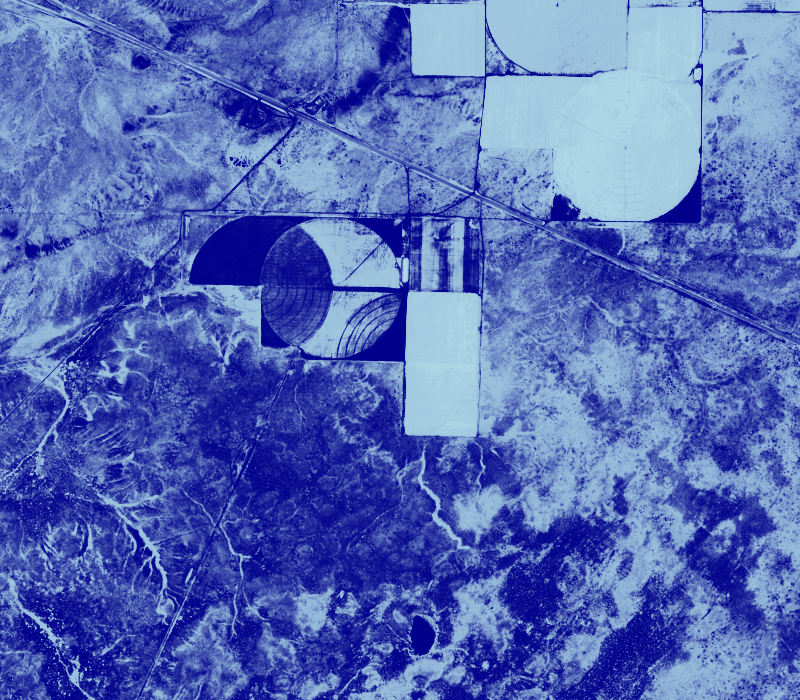
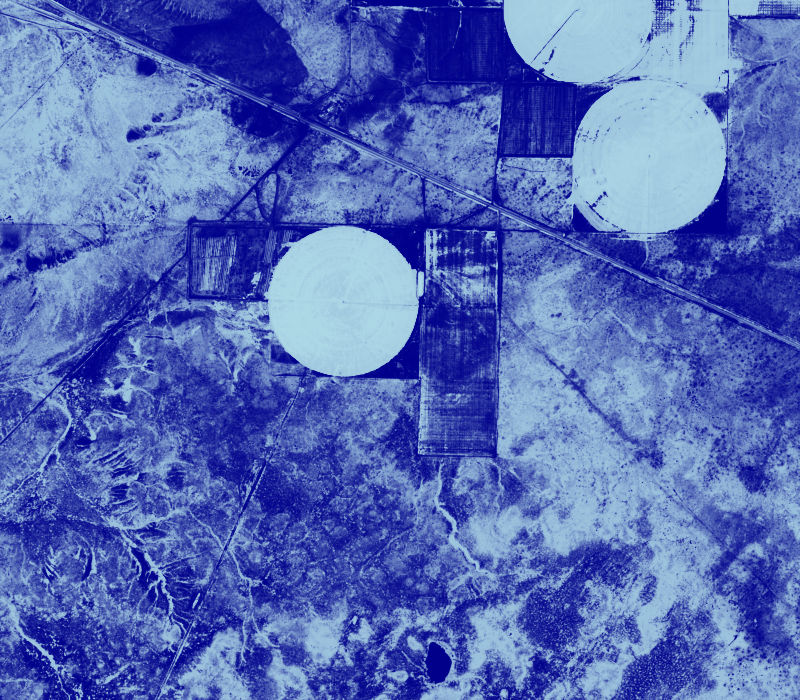
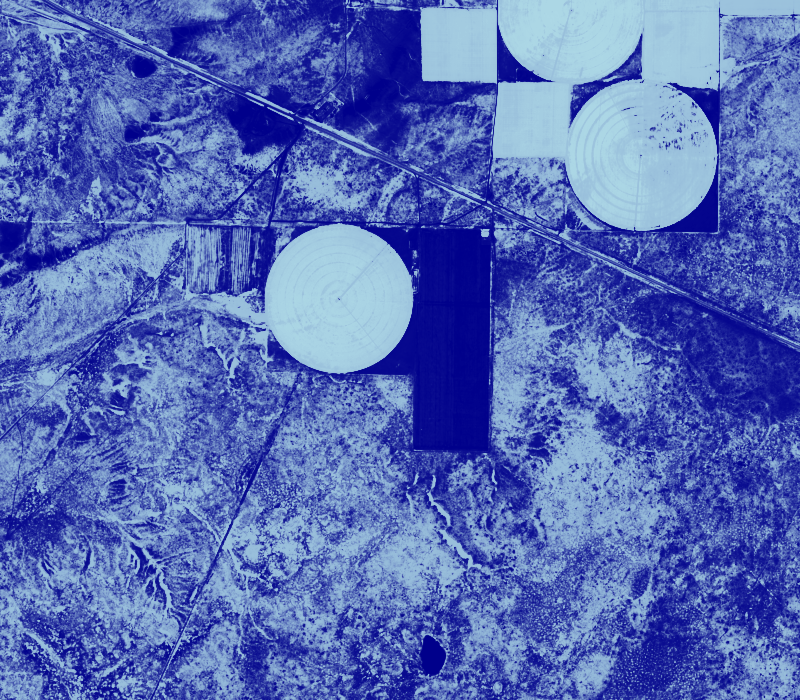

In [8]:
from datashader.colors import  Hot
from datashader.transfer_functions import shade, Images
import xarray as xr

# Convert to DataArrays of the same size
agg1 = xr.DataArray(data=img1, name='2011-07-01', dims=['x', 'y', 'band'])[:700, :800, :]
agg2 = xr.DataArray(data=img2, name='2013-08-18', dims=['x', 'y', 'band'])[:700, :800, :]
agg3 = xr.DataArray(data=img3, name='2019-07-14', dims=['x', 'y', 'band'])[:700, :800, :]

# Merge Arrays into single dataset
ds = xr.merge([agg1, agg2, agg3])

# Near-Infrared Band
Images(shade(ds['2011-07-01'][:, :, 1]),
       shade(ds['2013-08-18'][:, :, 1]),
       shade(ds['2019-07-14'][:, :, 1]))

Normalize the images using the NDVI function available on Xarray-spatial multispectral module.


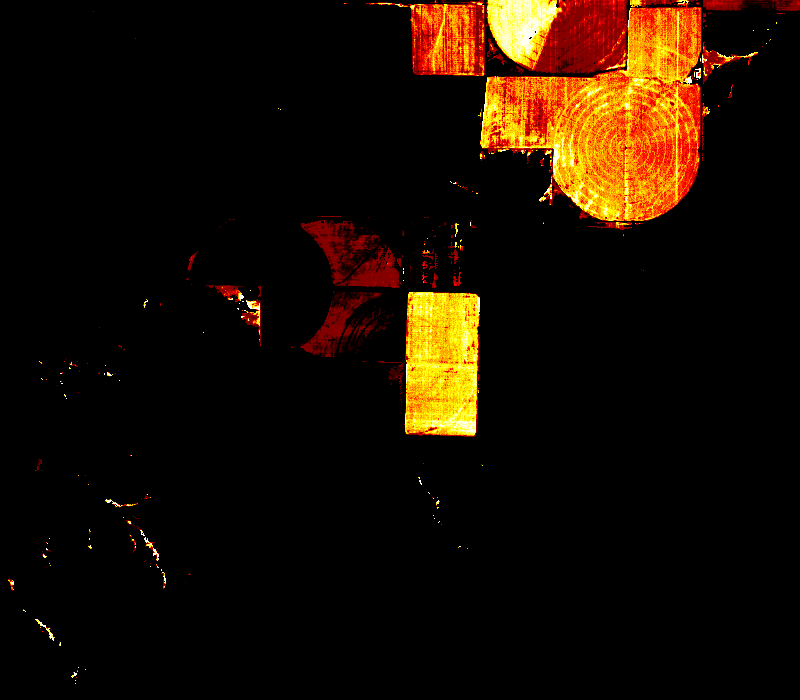
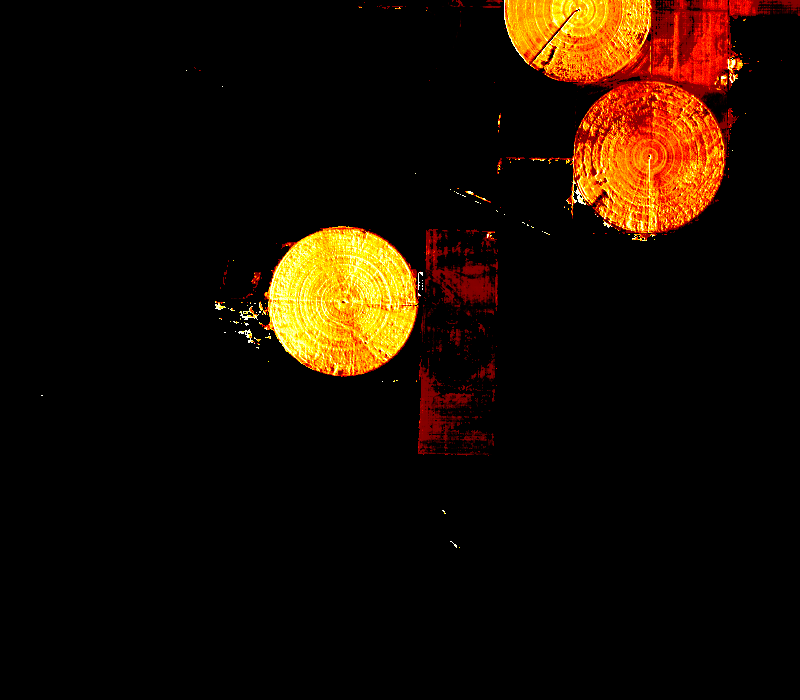
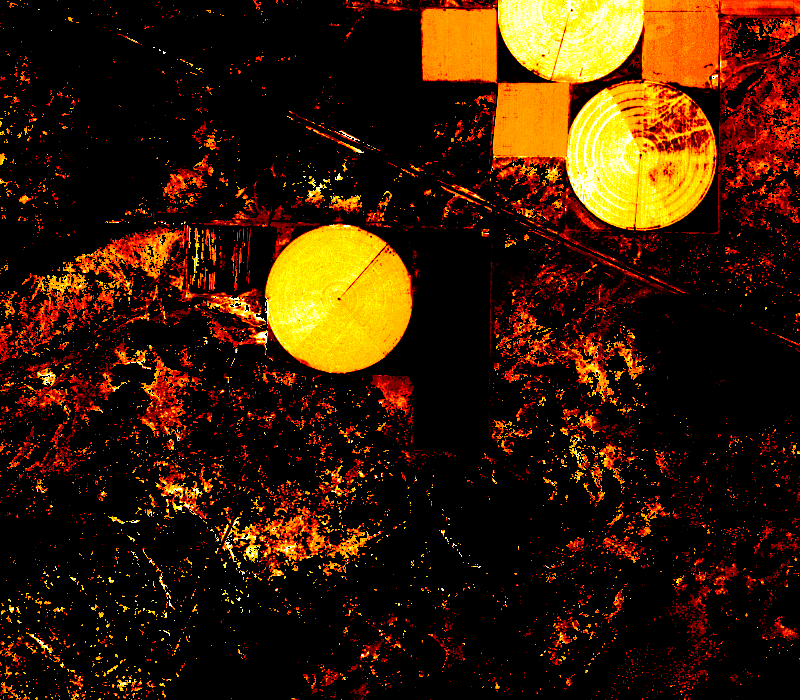

In [9]:
from xrspatial.multispectral import ndvi

# Create arrays using the NIR band (0) and the red band (1)
ndvi_2011 = ndvi(nir_agg=ds['2011-07-01'][:, :, 1], red_agg=ds['2011-07-01'][:, :, 0], name='2011-07-01')
ndvi_2013 = ndvi(nir_agg=ds['2013-08-18'][:, :, 1], red_agg=ds['2013-08-18'][:, :, 0], name='2013-08-18')
ndvi_2019 = ndvi(nir_agg=ds['2019-07-14'][:, :, 1], red_agg=ds['2019-07-14'][:, :, 0], name='2019-07-14')

# Merge Arrays into single dataset
ds_ndvi = xr.merge([ndvi_2011, ndvi_2013, ndvi_2019])

Images(shade(ndvi_2011, cmap=Hot),
       shade(ndvi_2013, cmap=Hot),
       shade(ndvi_2019, cmap=Hot))

Then use `xrspatial.classify.natural_breaks` to separate the NDVI images into bins of the same size.


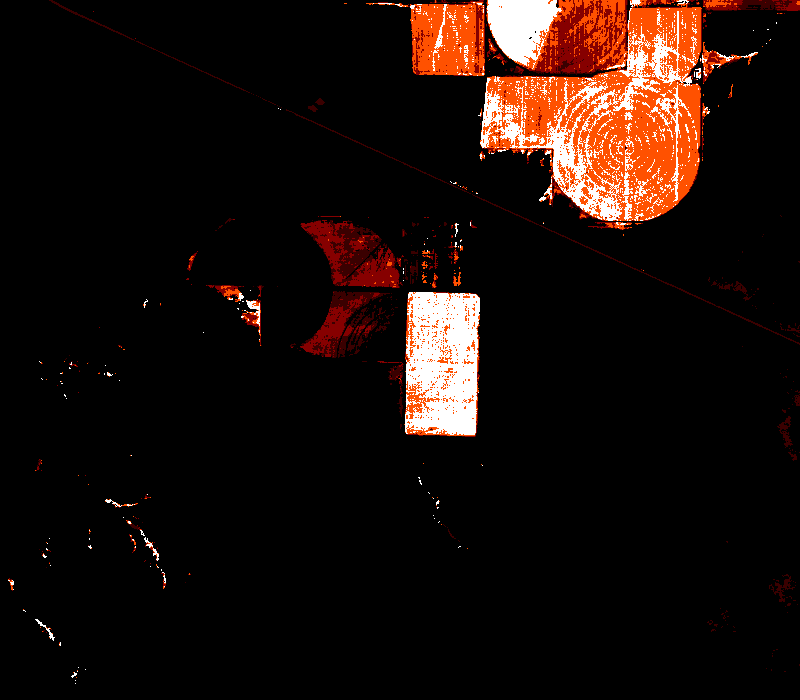
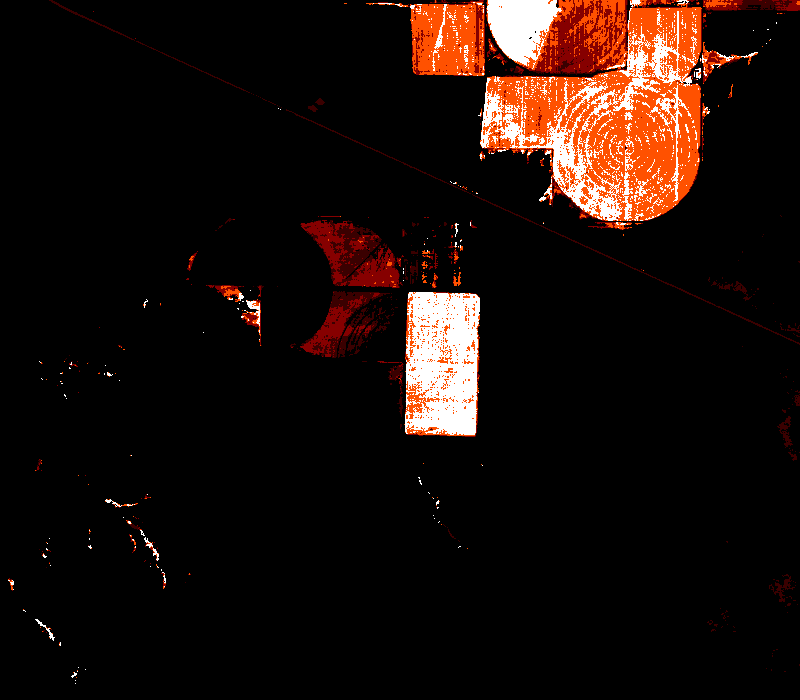
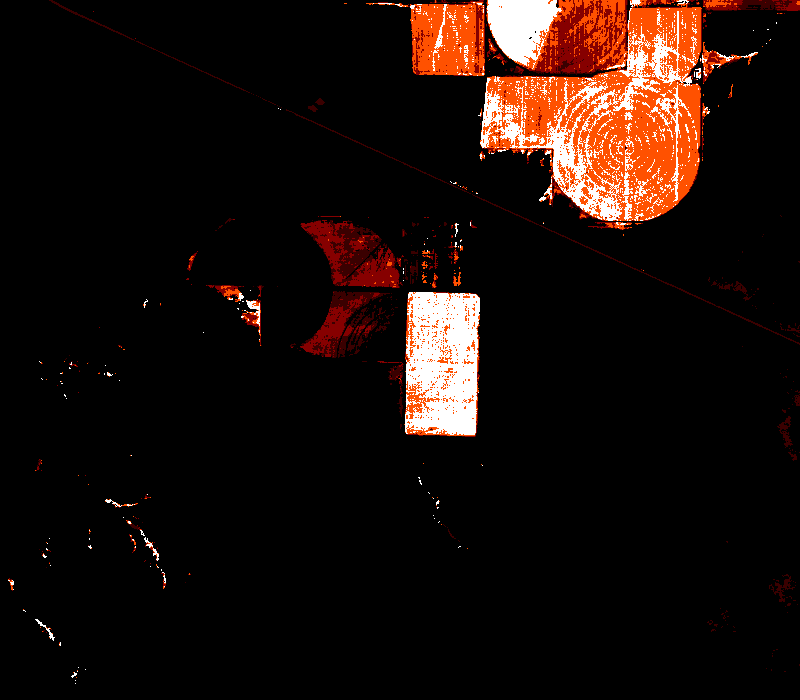

In [10]:
from xrspatial.classify import natural_breaks

nb_2011 = natural_breaks(ndvi_2011, num_sample=500)
nb_2013 = natural_breaks(ndvi_2013, num_sample=500)
nb_2019 = natural_breaks(ndvi_2019, num_sample=500)

nb_2011 = nb_2011.rename('nb_2011')
nb_2013 = nb_2011.rename('nb_2013')
nb_2019 = nb_2011.rename('nb_2010')

nb_ndvi = xr.merge([nb_2011, nb_2013, nb_2019])

Images(shade(nb_2011, cmap=Hot).rename('2011-07-01'),
       shade(nb_2013, cmap=Hot).rename('2013-08-18'),
       shade(nb_2019, cmap=Hot).rename('2019-07-14'))

#### Combine

`xrspatial.local.combine_arrays` allow the combination of rasters so that a unique output value is assigned to each unique combination of input values.

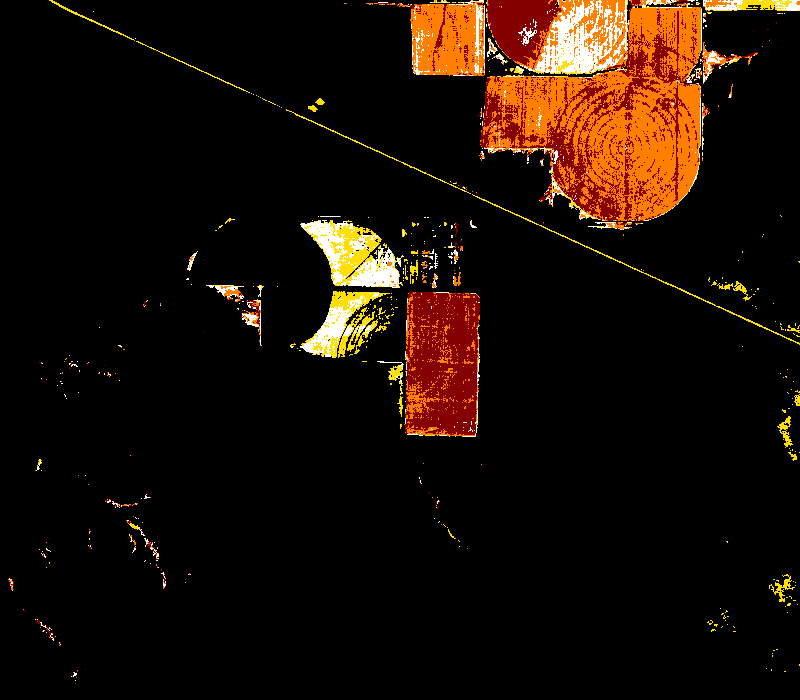

In [11]:
from xrspatial.local import combine_arrays

combine_agg = combine_arrays(nb_2011, nb_2013, nb_2019)

shade(combine_agg, cmap=Hot)

#### Equal To Frequency

`xrspatial.local.equal_frequency` evaluates on a cell-by-cell basis the number of times the values in a set of rasters are equal to another raster.

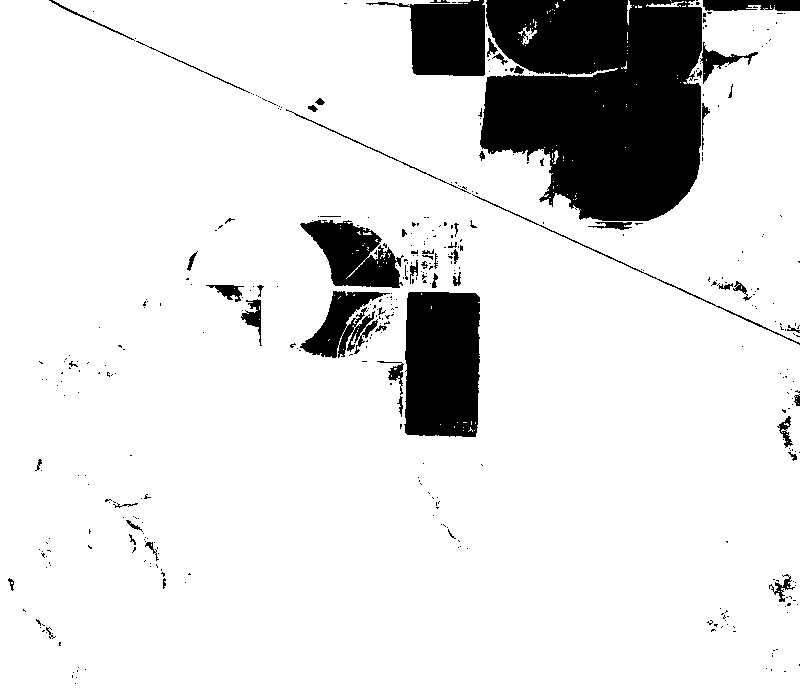

In [12]:
from xrspatial.local import equal_frequency

arr_zeros = xr.DataArray(np.full_like(ndvi_2011.data, 0))

nb_ef_zeros = equal_frequency(arr_zeros, [nb_2011, nb_2011, nb_2019])

shade(nb_ef_zeros, cmap=Hot)

#### Greater Than Frequency

`xrspatial.local.greater_frequency` evaluates on a cell-by-cell basis the number of times a set of rasters is greater than another raster.

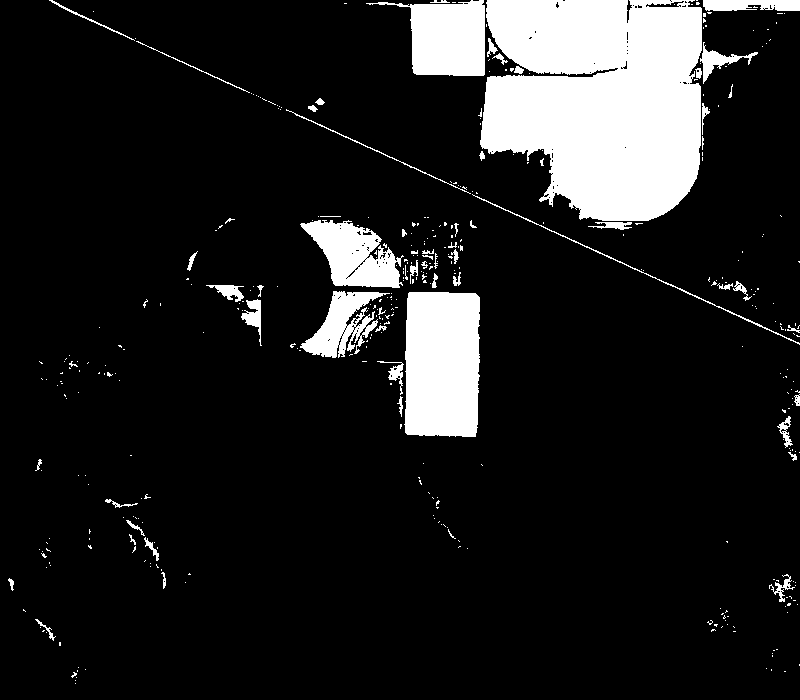

In [13]:
from xrspatial.local import greater_frequency

arr_zeros = xr.DataArray(np.full_like(ndvi_2011.data, 0))

nb_gf_zeros = greater_frequency(arr_zeros, [nb_2011, nb_2011, nb_2019])

shade(nb_gf_zeros, cmap=Hot)

#### Highest Position

`xrspatial.local.highest_array` determines on a cell-by-cell basis the position of the raster with the maximum value in a set of rasters.

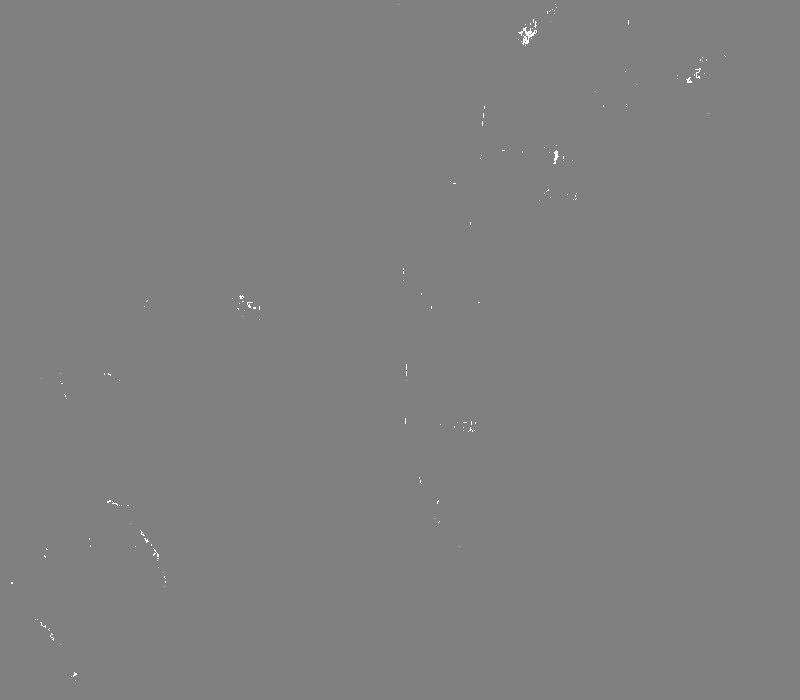

In [14]:
from xrspatial.local import highest_array

ha = highest_array(nb_2011, nb_2011, nb_2019)

shade(ha, cmap=['gray'])

#### Less Than Frequency

`xrspatial.local.lesser_frequency` evaluates on a cell-by-cell basis the number of times a set of rasters is less than another raster.

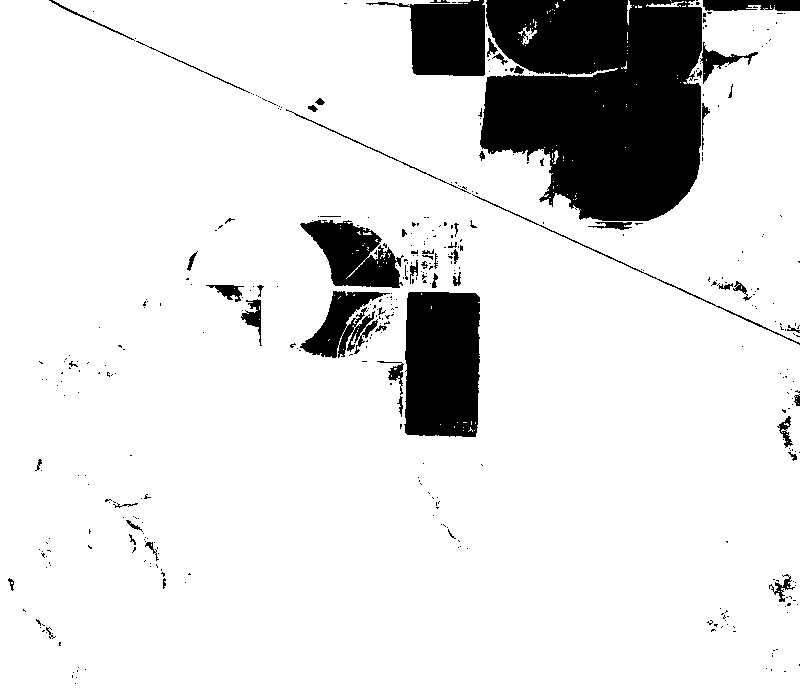

In [15]:
from xrspatial.local import lesser_frequency

val_arr = xr.DataArray(np.full_like(ndvi_2011.data, 0.5))

lf = lesser_frequency(val_arr, [nb_2011, nb_2011, nb_2019])

shade(lf, cmap=Hot)

#### Lowest Position

`xrspatial.local.lowest_array` determines on a cell-by-cell basis the position of the raster with the minimum value in a set of rasters.

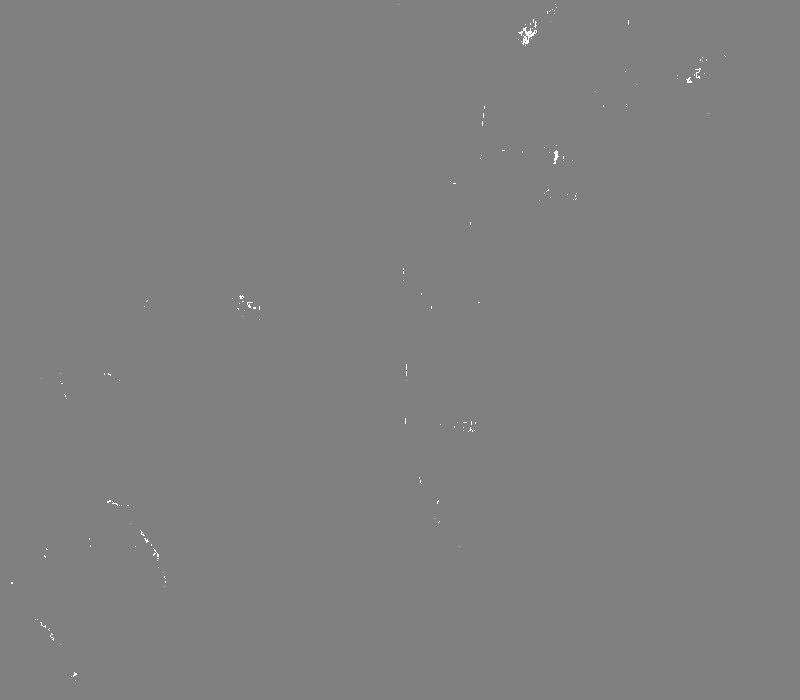

In [16]:
from xrspatial.local import lowest_array

la = lowest_array(nb_2011, nb_2011, nb_2019)

shade(la, cmap=['gray'])

#### Popularity

`xrspatial.local.popularity` determines the value in an argument list that is at a certain level of popularity on a cell-by-cell basis which the number of occurrences of each value is specified by the first argument.

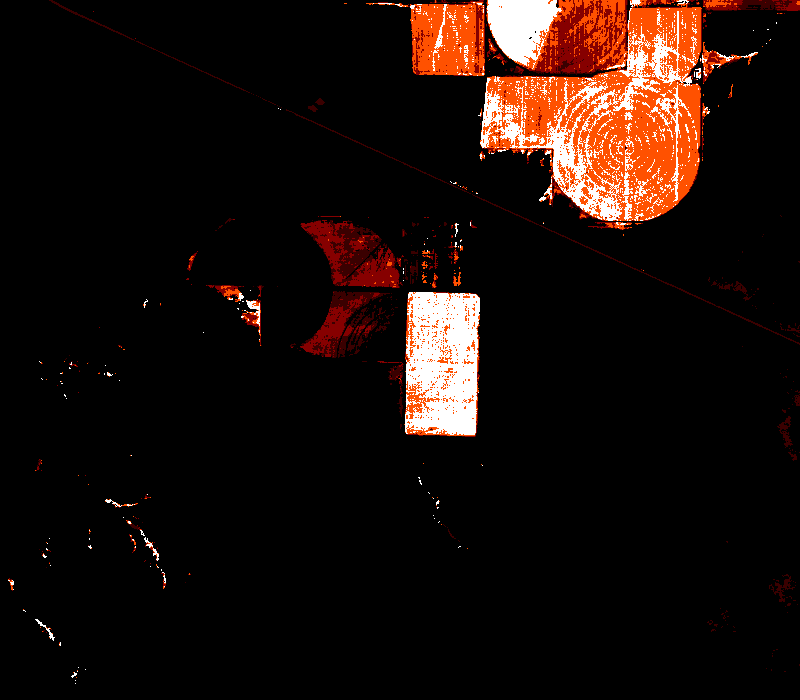

In [17]:
from xrspatial.local import popularity

val_arr = xr.DataArray(np.full_like(ndvi_2011.data, 2))

p = popularity(val_arr, [nb_2011, nb_2011, nb_2019])

shade(p, cmap=Hot)

#### Rank

`xrspatial.local.rank` rank the values from the set of input rasters on a cell-by-cell basis which of these gets returned is determined by the value of the rank input raster.

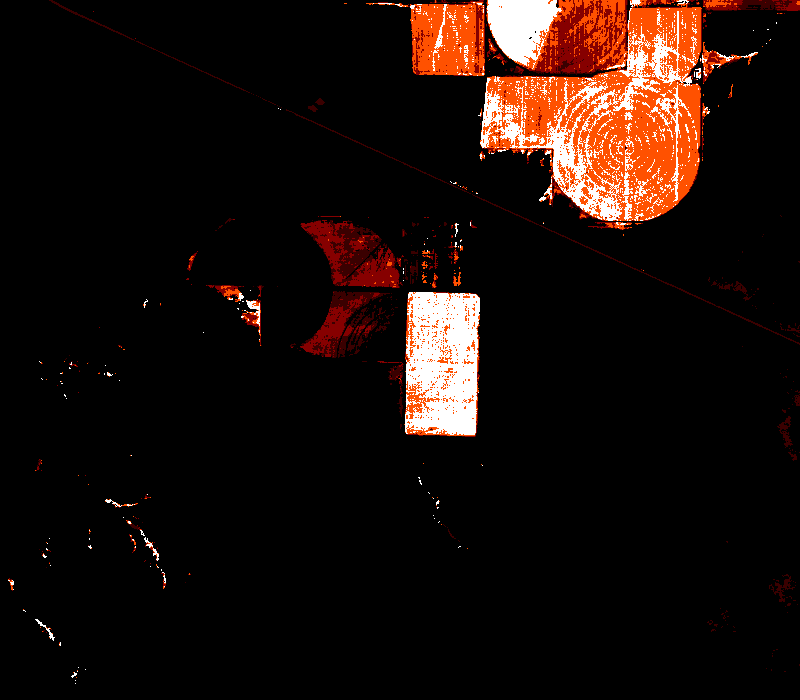

In [18]:
from xrspatial.local import rank

val_arr = xr.DataArray(np.full_like(ndvi_2011.data, 3))

r = rank(val_arr, [nb_2011, nb_2011, nb_2019])

shade(r, cmap=Hot)